<a href="https://colab.research.google.com/github/pallavibekal/IISC--Parallel-Computing/blob/main/IISC_M2_NB_MiniProject_04_Fare_Amount_Prediction_Using_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Linear Regression on a Large Dataset Using Dask Library

## Learning Objectives

At the end of the mini-project, you will be able to :

- understand how dask handles large dataset over pandas dataframe 
- perform exploratory data analysis on a large dataset (2 Million rows) using dask
- implement linear regression model using dask library and make predictions


## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

## Information

### Dask 
[Dask](https://dask.pydata.org/en/latest/) is an open source project that gives abstractions over NumPy Arrays, Pandas Dataframes and regular lists, allowing you to run operations on them in parallel, using multicore processing.

We can summarize the basics of Dask as follows:

* processes data that doesn’t fit into memory by breaking it into blocks and specifying task chains

* parallelizes execution of tasks across cores and even nodes of a cluster

* moves computation to the data rather than the other way around, to minimize communication overhead

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://drive.google.com/uc?export=view&id=1Biu7BEobFnJUxX7vZvgYfo4mi_Bz_ctl)




## Grading = 10 Points

In [ ]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[delayed]
!pip -qq install dask[dataframe] --upgrade

In [ ]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[delayed]
!pip -qq install dask[dataframe] --upgrade

#### Importing Necessary Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
from dask.distributed import Client
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dask.distributed import Client, progress
client = Client()

In [ ]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

--2021-09-11 05:29:15--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231900522 (221M) [application/octet-stream]
Saving to: ‘Dask_MP_dataset.csv.1’

Dask_MP_dataset.csv 100%[===================>] 221.16M  19.2MB/s    in 13s     

2021-09-11 05:29:29 (16.6 MB/s) - ‘Dask_MP_dataset.csv.1’ saved [231900522/231900522]



#### Exercise 1: Read the dataset using dask library and compare the time of execution with pandas library.

**Hint:** pass `dtype` for passenger_count as `int64`

In [ ]:
%%time
# YOUR CODE HERE
df_dd = dd.read_csv('Dask_MP_dataset.csv')

df_dd["passenger_count"].astype('int64')
print(df_dd.columns)

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')
CPU times: user 15.1 ms, sys: 11.3 ms, total: 26.4 ms
Wall time: 27 ms


In [ ]:
df_dd.isnull().sum().compute()

Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64

#### Use pandas to read the dataset and compare the time taken

In [ ]:
%%time
# YOUR CODE HERE
df_pd = pd.read_csv('Dask_MP_dataset.csv')


CPU times: user 4.41 s, sys: 405 ms, total: 4.82 s
Wall time: 4.78 s


### Data Analysis (2 Points)



#### Exercise 2: Drop the unnecessary columns. Also drop the duplicate rows and the rows having null values.

**Hint:** Drop those columns which are not useful in EDA as well as model implementation

In [ ]:
# Check shape before
df_dd.shape[0].compute(),df_dd.shape[1]

(2000000, 9)

In [ ]:
""" Drop unnecessary columns """
# YOUR CODE HERE
df_dd1 = df_dd.drop(axis=0, columns='key')
df_dd_dropped = df_dd1.drop(axis=0, columns='Unnamed: 0')

In [ ]:
# Check shape after
df_dd_dropped.shape[0].compute(),df_dd_dropped.shape[1]

(2000000, 7)

In [ ]:
""" Drop duplicate rows """
# YOUR CODE HERE
df_dd_dropped_duplicates = df_dd_dropped.drop_duplicates()

In [ ]:
# Check shape after dropping duplicates
df_dd_dropped_duplicates.shape[0].compute(),df_dd_dropped_duplicates.shape[1]


(1999997, 7)

In [ ]:
""" drop NA rows """
# YOUR CODE HERE
df_dd_dropped_NA = df_dd_dropped_duplicates.dropna()

#### Exercise 3: Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60].

**Hint:** [sns.hisplot()](https://stackoverflow.com/questions/51027636/seaborn-histogram-with-bigdata/51027895) and use `.between` to plot the graph for given range 


(array([470522., 964684., 307598., 102592.,  51452.,  33891.,  17334.,
         12844.,  19443.,  14127.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

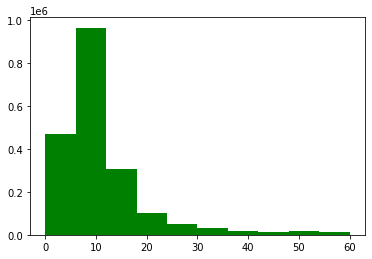

In [ ]:
""" explore and plot the density plot of fare_amount """
# YOUR CODE HERE
plt.hist(df_dd_dropped_NA["fare_amount"].compute(),10, range=[0,60], facecolor='green', align='mid')


#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

In [ ]:
""" Initialize a client """
# YOUR CODE HERE
#import multiprocessing

#multiprocessing.cpu_count()


#import psutil
#psutil.cpu_count()

client

Client Scheduler: tcp://127.0.0.1:34029 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 13.62 GB


### EDA based on Time (2 Points)

#### Exercise 4: Extract day of the week (dow), hour, month and year from `pickup_datetime`.

**Hint:** use `pd.to_datetime()` function as dask does not have this functionality in it.

Remember to use `.compute()` while passing the dask dataframe in defined function.

In [ ]:
# Shape after handling NAs
df_dd_dropped_NA.shape[0].compute(),df_dd_dropped_NA.shape[1]

(1999983, 7)

In [ ]:
  #New date time column
  df_dd_dropped_NA["new_date_time"] = dd.to_datetime(df_dd_dropped_NA["pickup_datetime"] )

In [ ]:
  df_dd_dropped_NA.compute()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_date_time
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 17:26:21+00:00
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 16:52:16+00:00
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18 00:35:00+00:00
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 04:30:42+00:00
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 07:51:00+00:00
...,...,...,...,...,...,...,...,...
342490,4.0,2014-11-17 13:51:02 UTC,-73.950787,40.770836,-73.951043,40.774543,1,2014-11-17 13:51:02+00:00
342491,7.0,2013-02-25 17:51:28 UTC,-73.983035,40.748276,-73.974725,40.741978,1,2013-02-25 17:51:28+00:00
342492,10.5,2013-07-12 22:03:41 UTC,-74.003482,40.743577,-73.976758,40.765265,1,2013-07-12 22:03:41+00:00
342493,10.9,2009-01-17 09:35:37 UTC,-73.971819,40.797243,-73.985921,40.752459,3,2009-01-17 09:35:37+00:00


In [ ]:
# Columns for month, year, day, hour

df_dd_dropped_NA['year']= df_dd_dropped_NA['new_date_time'].dt.year
df_dd_dropped_NA['month']= df_dd_dropped_NA['new_date_time'].dt.month
df_dd_dropped_NA['day']= df_dd_dropped_NA['new_date_time'].dt.dayofweek
df_dd_dropped_NA['hour']= df_dd_dropped_NA['new_date_time'].dt.hour

In [ ]:
df_dd_dropped_NA.compute()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_date_time,year,month,day,hour
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 17:26:21+00:00,2009,6,0,17
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 16:52:16+00:00,2010,1,1,16
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18 00:35:00+00:00,2011,8,3,0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21 04:30:42+00:00,2012,4,5,4
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09 07:51:00+00:00,2010,3,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...
342490,4.0,2014-11-17 13:51:02 UTC,-73.950787,40.770836,-73.951043,40.774543,1,2014-11-17 13:51:02+00:00,2014,11,0,13
342491,7.0,2013-02-25 17:51:28 UTC,-73.983035,40.748276,-73.974725,40.741978,1,2013-02-25 17:51:28+00:00,2013,2,0,17
342492,10.5,2013-07-12 22:03:41 UTC,-74.003482,40.743577,-73.976758,40.765265,1,2013-07-12 22:03:41+00:00,2013,7,4,22
342493,10.9,2009-01-17 09:35:37 UTC,-73.971819,40.797243,-73.985921,40.752459,3,2009-01-17 09:35:37+00:00,2009,1,5,9


#### Exercise 5: a.) Plot the taxi trip by hour of the day

* Partition the data into segments using `dask.from_pandas()`

* Plot the taxi trip for hour of the day. **Hint:** [sns.catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

In [ ]:
bins = [_ for _ in range(0, 24, 1)]
sns.histplot(df_dd_dropped_NA['hour'], bins=bins, kde=False)
plt.show()

#### Exercise 5: b.) Plot the taxi trip repartition by day of the week (dow)

In [ ]:
""" taxi trip repartition by day of the week """
# YOUR CODE HERE
bins = [_ for _ in range(0, 7, 1)]
sns.histplot(df_dd_dropped_NA['day'], bins=bins, kde=False)
plt.show()

#### Exercise 6: a.) Draw a plot between the target variable and passenger count and analyze it. 

In [ ]:
df_dd_dropped_NA.repartition(npartitions=3)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_date_time,year,month,day,hour
npartitions=3,,,,,,,,,,,,
,float64,object,float64,float64,float64,float64,int64,datetime64[ns],int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


Text(0, 0.5, 'Fare Amount')

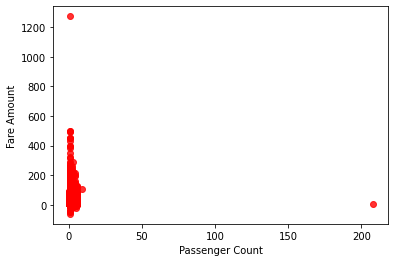

In [ ]:
plt.scatter(df_pd["passenger_count"].values,df_pd["fare_amount"].values,c='red',alpha=0.8)
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount")

In [ ]:
""" passenger count feature """
# YOUR CODE HERE

plt.scatter(df_dd_dropped_NA["passenger_count"].compute(),df_dd_dropped_NA["fare_amount"].compute(),c='red',alpha=0.8)

plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount")

In [ ]:
import statistics

#### Exercise 6: b.) Draw a plot between the target variable and hour and analyze it. 

In [ ]:
# plt.scatter(df_pd["hour"],df_pd["fare_amount"],c='red',alpha=0.8)

In [ ]:
""" fare amount by hour """
# YOUR CODE HERE

#plt.scatter(df_dd_dropped_NA["hour"].compute(),df_dd_dropped_NA["fare_amount"].compute(),c='green',alpha=0.8)

plt.xlabel("Hour")
plt.ylabel("Fare Amount")

### Feature Engineering (1 Point)

#### Exercise 7: Compute the Haversine distance between pickup and dropoff point

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)

* Add the "distance" feature to the dataset and plot its distribution

In [ ]:
""" distance feature """
# YOUR CODE HERE

!pip install haversine
import haversine as hs
from math import radians
from dask import delayed


In [ ]:
df_dd_dist = {'pickup_latitude':np.radians(df_dd_dropped_NA["pickup_latitude"]),
              'pickup_longitude':np.radians(df_dd_dropped_NA["pickup_longitude"]),
              'dropoff_latitude':np.radians(df_dd_dropped_NA["pickup_latitude"]),
              'dropoff_longitude':np.radians(df_dd_dropped_NA["pickup_latitude"])}

In [ ]:
""" plot the distance feature (take distance < 50) """
# YOUR CODE HERE
X = np.array([df_dd_dist['pickup_latitude'],df_dd_dist['pickup_longitude']]).T
Y = np.array([df_dd_dist['dropoff_latitude'],df_dd_dist['dropoff_longitude']]).T

dist = DistanceMetric.get_metric('haversine')
distance_in_km = list()
for i in range(0,X.shape[0]):
  loc1=(X[i][0],X[i][1])
  loc2=(Y[i][0],Y[i][1])
  distance_in_km.append(hs.haversine(loc1,loc2))

In [ ]:
df_dd_dropped_NA['distance'] = distance_in_km


In [ ]:
df_dd_dropped_NA = dd.from_pandas(df_dropped_NA, npartitions=5)


### Correlation between distance and fare amount (1 Point)

In [ ]:
""" correlation between fare_amount and distance """
# YOUR CODE HERE

np.correlate(df_dd_dropped_NA["fare_amount"].compute(),df_dd_dropped_NA["distance"].compute())


### Preparing dataset for model implementation

**Note:** Use the above modified dataset for modelling.

In [ ]:
# YOUR CODE HERE

### Removing outliers from training set Based on Coordinates (1 Point)

#### Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City.

**Hint:** Given the co-ordinates of New York city are Latitude: 40.7128° and Longitude: -74.0060°. You can include the pickup and drop off points such that there left and right value mean will be the given co-ordinate value. 

Also, choose nearest extreme values.

Use `.between()` and pass left and right value attributes accordingly.

In [ ]:
""" remove the outliers in pickup latitude longitude and drop off latitude and longitude """
# YOUR CODE HERE 

#Function to calculate range of 3 standard deviations left /right to the mean
def range_for_outliers(col):
  a = np.mean(col)
  b = np.stdev(col)
  left= a-3*b
  right = a + 3*b
  return left, right

# Handle each variable individually

l1,r1 = range_for_outliers(df_dd_dropped_NA['pickup_latitude'])
df_dd_dropped_NA = df_dd_dropped_NA[df_dd_dropped_NA["pickup_latitude"].between(left = l1, right = r1)]

l2,r2 = range_for_outliers(df_dd_dropped_NA['pickup_longitude'])
df_dd_dropped_NA = df_dd_dropped_NA[df_dd_dropped_NA["pickup_longitude"].between(left = l2, right = r2)]

l3,r3 = range_for_outliers(df_dd_dropped_NA['dropoff_latitude'])
df_dd_dropped_NA = df_dd_dropped_NA[df_dd_dropped_NA["dropoff_latitude"].between(left = l3, right = r3)]

l4,r4 = range_for_outliers(df_dd_dropped_NA['dropoff_longitude'])
df_dd_dropped_NA = df_dd_dropped_NA[df_dd_dropped_NA["dropoff_longitude"].between(left = l4, right = r4)]



### Modelling (3 Points)

#### Exercise 9: Divide the data into train and test splits with X as feature variables and y as target variable

* Divide data into train test split with 70-30 ratio, Hint: `train_test_split()`

* As dask functions operate lazily so, before calling `.fit()` function, call the dask dataframe with `.compute()`.
* Convert X_train and y_train into array using `.values` as [dask's](https://ml.dask.org/modules/api.html) `.fit()` function takes array as attribute

In [ ]:
""" select the target and feature variables and split the data into train and test """
# YOUR CODE HERE

data = df_dd_dropped_NA
features_list = ['distance','passenger_count', 'year','month','day','hour']
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, features_list], data.loc[:,['fare_amount'], test_size=0.3, train_size=0.7, random_state=0)


#### Exercise 10: Predict the test data and calculate the mean squared error and r2 score.

**Hint:** Remember to call `.compute()` function as dask functions operate lazily and convert the dask dataframe to `.values` (Array type) as suggested in above exercise

In [ ]:
""" predict the values """
# YOUR CODE HERE
linreg = LinearRegression()
linreg.fit(X_train.compute().values, y_train.compute().values)
y_pred = linreg.predict(X_test.compute().values)


In [ ]:
""" compute mean squared error and r2_score """
# YOUR CODE HERE

mse = mean_squared_error(y_test.compute().values, y_pred.compute())
r2 = r2_score(y_test.compute().values, y_pred.compute())
mse, r2


### Report Analysis
* Discuss the pros and cons of using dask
* Derive the insights and discuss
* Comment on the performance metrics (MSE, R^2 score)
